In [3]:
import pandas as pd
import os
import seaborn as sns

In [4]:
data_dir = os.path.join(os.getcwd() , "data")

smartphone_data = {}
wearable_data = {}

smartphone_data_files = ["ActivityEvent.csv", "ActivityTransition.csv", "AppUsageEvent.csv", 
                         "BatteryEvent.csv", "CallEvent.csv", "ChargeEvent.csv", "Connectivity.csv", 
                         "DataTraffic.csv", "InstalledApp.csv", "Location.csv", "MediaEvent.csv", 
                         "MessageEvent.csv", "OnOffEvent.csv", "PowerSaveEvent.csv", "RingerModeEvent.csv", 
                         "ScreenEvent.csv", "WiFi.csv"] 

wearable_data_files = ["Acceleration.csv", "AmbientLight.csv", "Calorie.csv", "Distance.csv", "EDA.csv", 
                       "HR.csv", "RRI.csv", "SkinTemperature.csv", "StepCount.csv", "UltraViolet.csv", ]

## Research Question

Does the time and type of first phone interaction of the day influence stress levels and attention?

## Research Plan

We plan on using a combination of smartphone and wristband data to determine participant sleep and, in particular, the time they wake up. Based on the waking up times, we'd like to understand and categorize participants' first interaction with their smartphones (e.g., type of app(s) and how long it/they were used for). We aim to compare these findings to the self-reported in-situ affective and cognitive states to see whether there are any interesting significant correlations.

## Literature

After a first look at the existing literature on the topic we found that there is quite some work done on the matter of smartphone usage before sleep but limited papers referring to effects of smartphone usage after waking up. Despite there being not much scientific information on the topic, several blogposts and articles suggest there are benefits to avoiding one's phone in the morning.

### Possibly Relevant Literature
- Thomée S. Mobile Phone Use and Mental Health. A Review of the Research That Takes a Psychological Perspective on Exposure. Int J Environ Res Public Health. 2018 Nov 29;15(12):2692. doi: 10.3390/ijerph15122692. PMID: 30501032; PMCID: PMC6314044.
- Transdisciplinary Tobacco Use Research Center (TTURC) Tobacco Dependence; Baker TB, Piper ME, McCarthy DE, Bolt DM, Smith SS, Kim SY, Colby S, Conti D, Giovino GA, Hatsukami D, Hyland A, Krishnan-Sarin S, Niaura R, Perkins KA, Toll BA. Time to first cigarette in the morning as an index of ability to quit smoking: implications for nicotine dependence. Nicotine Tob Res. 2007 Nov;9 Suppl 4(Suppl 4):S555-70. doi: 10.1080/14622200701673480. PMID: 18067032; PMCID: PMC2933747.
- G.C. Sih, K.K. Tang, On–off switching of theta–delta brain waves related to falling asleep and awakening, heoretical and Applied Fracture Mechanics, Volumes 63–64,2013,Pages 1-17,ISSN 0167-8442,https://doi.org/10.1016/j.tafmec.2013.03.001.

### Interesting articles and other sources
- "76% of people check their phone within 30 minutes of waking up (and 43% even do it within 5 minutes)" https://www2.deloitte.com/content/dam/Deloitte/us/Documents/technology-media-telecommunications/us-global-mobile-consumer-survey-2016-executive-summary.pdf
- https://www.forbes.com/sites/forbescoachescouncil/2021/04/02/why-you-should-stop-checking-your-phone-in-the-morning-and-what-to-do-instead/?sh=58d0f8982684


## Extracting and Formatting

### All participants in one dataframe

In [5]:
# Data we identified to be useful for our research quesiton

smartphone_data_files_rq1 = ["ActivityEvent.csv", "ActivityEvent.csv", "Location.csv"] 
wearable_data_files_rq1 = ["Acceleration.csv", "HR.csv"]

smartphone_data_files_exploration = ["AppUsageEvent.csv", "Location.csv"] 
wearable_data_files_exploration = ["HR.csv","SlinTemperature", "AmbientLight.csv", "UltraViolet.csv"]
esm_file_path = os.path.join(data_dir,"SubjData", "EsmResponse.csv")

In [6]:
# build dicts to acces data files (also adding participant identifier column)

for smartphone_data_file in smartphone_data_files_exploration: 
    dfs = {}
    for p in os.listdir("data"):
        if p.startswith("P"): # Only get Participant Directories
            df = pd.read_csv(os.path.join(data_dir, p, smartphone_data_file)) # load df from csv
            df["participant"] = p # add column indicating participant id
            dfs[p] = df
    smartphone_data_table = smartphone_data_file.replace(".csv", "")   
    smartphone_data[smartphone_data_table] = pd.concat(dfs.values(), axis = 0)

In [7]:
for wearable_data_file in wearable_data_files_exploration:
    dfs = {}
    for p in os.listdir("data"):
        if p.startswith("P"): # Only get Participant Directories
            df = pd.read_csv(os.path.join(data_dir, p, wearable_data_file))
            df["participant"] = p # add column indicating participant id
            dfs[p] = df
    wearable_data_table = wearable_data_file.replace(".csv", "")   
    wearable_data[wearable_data_table] = pd.concat(dfs.values(), axis = 0)

### One dataframe per participant

In [17]:
p = {}

In [129]:
P = "P09"
amb_df = df_to_timeseries(pd.read_csv(os.path.join(data_dir,P, "AmbientLight.csv")))
#amb_df = amb_df.resample("15").mean()
#amb_df["brightness"] = amb_df["brightness"].interpolate()

uv_df = df_to_timeseries(pd.read_csv(os.path.join(data_dir,P, "UltraViolet.csv")))[["intensity"]]

app_df = df_to_timeseries(pd.read_csv(os.path.join(data_dir,P, "AppUsageEvent.csv")))[["name","category"]]

loc_df = df_to_timeseries(pd.read_csv(os.path.join(data_dir,P, "Location.csv")))[["longitude","latitude","altitude"]]

esm_df = df_to_timeseries(esm_data[esm_data["pcode"]==P].copy(),timestamp_col="responseTime")[["valence","arousal","attention","stress"]]
amb_df.shape, uv_df.shape, app_df.shape, loc_df.shape

((468427, 1), (3900, 1), (16669, 2), (14957, 3))

In [127]:
# join tables using merge_asof for closest timestamp value
joined_df = pd.merge_asof(amb_df, uv_df, left_index=True,right_index=True)
joined_df = pd.merge_asof(joined_df, loc_df, left_index=True,right_index=True)
joined_df = pd.merge_asof(joined_df, app_df, left_index=True,right_index=True)
joined_df = pd.merge_asof(joined_df, esm_df, left_index=True,right_index=True)

In [130]:
joined_df.columns(["app_name", "app_category", "ambietal_brightness", "uv_intensity", "longitude", "latitude"])

TypeError: 'Index' object is not callable

In [ ]:
for p_folder in os.listdir(data_dir):
    if p_folder.startswith("P"): # Only get Participant Directories
        pn = int(p_folder[1:]) # Participant as int
        for wearable_data_file in wearable_data_files_exploration:
            p[pn] = pd.read_csv(os.path.join(data_dir,p_folder, smartphone_data_file)) # load df from csv
            

### ESM data

In [8]:
esm_data = pd.read_csv(esm_file_path)

## Data Exploration

### App categories

In [9]:
# Group the data first by category and participant, then count the number of unique participants
participant_counts = smartphone_data["AppUsageEvent"].groupby(['category', 'participant']).size().groupby('category').count()

# Combine the app counts and participant counts into a DataFrame
category_counts = smartphone_data["AppUsageEvent"].category.value_counts().reset_index()
category_counts.columns = ['Category', 'AppUsageEventCount']
category_counts['ParticipantCount'] = category_counts['Category'].map(participant_counts)

category_counts

,Category,AppUsageEventCount,ParticipantCount
0,COMMUNICATION,538695,77
1,TOOLS,175258,77
2,PERSONALIZATION,158669,55
3,SYSTEM,120235,77
4,SOCIAL,109561,73
5,HEALTH_AND_FITNESS,93145,77
6,FINANCE,24583,77
7,LIFESTYLE,21414,71
8,COMICS,17567,33
9,PRODUCTIVITY,17505,77


### Calories

In [14]:
calories_df = df_to_timeseries(wearable_data["Calorie"])
df
#[["caloriesToday"]].groupby("participant").mean()

,timestamp,intensity,exposureToday,totalExposure,participant
0,1556596918172,NONE,0,0,P62
1,1556596978178,NONE,0,0,P62
2,1556597038177,NONE,0,0,P62
3,1556597098172,NONE,0,0,P62
4,1556597158176,NONE,0,0,P62
...,...,...,...,...,...
4511,1557152136662,NONE,0,300000,P62
4512,1557152196647,NONE,0,300000,P62
4513,1557152256647,NONE,0,300000,P62
4514,1557152316646,NONE,0,300000,P62


In [14]:
smartphone_data["AppUsageEvent"]["category"][smartphone_data["AppUsageEvent"]["isSystemApp"] == False].unique()

array(['MISC', 'COMMUNICATION', 'PRODUCTIVITY', 'HEALTH_AND_FITNESS',
       'EDUCATION', 'SOCIAL', 'TRAVEL_AND_LOCAL', 'MAPS_AND_NAVIGATION',
       'SHOPPING', 'FINANCE', 'LIFESTYLE', 'PHOTOGRAPHY',
       'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'TOOLS',
       'MUSIC_AND_AUDIO', 'GAME', 'WEATHER', 'ENTERTAINMENT',
       'FOOD_AND_DRINK', 'VIDEO_PLAYERS', 'SPORTS', 'LIBRARIES_AND_DEMO',
       'PERSONALIZATION', 'HOUSE_AND_HOME', 'AUTO_AND_VEHICLES',
       'NEWS_AND_MAGAZINES', 'BEAUTY', 'ART_AND_DESIGN'], dtype=object)

In [92]:
smartphone_data["ScreenEvent"].type.unique()

array(['ON', 'OFF', 'UNLOCK'], dtype=object)

In [152]:
smartphone_data["AppUsageEvent"][smartphone_data["AppUsageEvent"]["category"]=="ART_AND_DESIGN"].sample(4)

,timestamp,name,packageName,isSystemApp,type,isUpdatedSystemApp,category,participant
24232,1558434811022,Canva,com.canva.editor,False,MOVE_TO_BACKGROUND,False,ART_AND_DESIGN,P33
24234,1558434814013,Canva,com.canva.editor,False,MOVE_TO_BACKGROUND,False,ART_AND_DESIGN,P33
24233,1558434811060,Canva,com.canva.editor,False,MOVE_TO_FOREGROUND,False,ART_AND_DESIGN,P33
24231,1558434810782,Canva,com.canva.editor,False,MOVE_TO_FOREGROUND,False,ART_AND_DESIGN,P33


In [21]:
esm_df = pd.read_csv(os.path.join(data_dir, "SubjData", "EsmResponse.csv"))
esm_df

,pcode,responseTime,scheduledTime,valence,arousal,attention,stress,duration,disturbance,change
0,P01,1557278103000,NaN,0,0,0,-1,20.0,3,-2
1,P01,1557278986000,1.557279e+12,-3,3,3,3,5.0,-1,-3
2,P01,1557281772000,1.557282e+12,-3,-2,2,2,15.0,3,-2
3,P01,1557287138000,NaN,2,-1,2,0,15.0,1,-1
4,P01,1557291117000,NaN,3,3,3,-3,20.0,1,0
...,...,...,...,...,...,...,...,...,...,...
5577,P80,1557125756000,1.557126e+12,1,2,3,1,15.0,3,-1
5578,P80,1557127903000,NaN,-1,1,3,2,20.0,-3,-1
5579,P80,1557136933000,NaN,1,-1,-2,1,5.0,3,-1
5580,P80,1557139401000,1.557139e+12,0,1,-1,-1,10.0,2,0


### Figuring TimeStamps out

Study conducted at different date intervals (Korean TimeZone): 
- April 30 to May 7 for P29–P53, 
- May 8 to May 15 for P01–P28, 
- May 16 to May 23 for P54–P80

In [120]:
def df_to_timeseries(df, timestamp_col="timestamp"):
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], unit="ms") # convert timestamp to datetime
    df.set_index(timestamp_col,inplace=True) # set it as index for TimeSeries purposes
    df = df.tz_localize("UTC") # need to localize a timezone
    df = df.tz_convert("Asia/Seoul") # convert it to Korean timezone
    return df

In [13]:
df = wearable_data["HR"][hr_df["participant"] == "P19"][["timestamp","bpm"]].copy() # Random particpant

df = df_to_timeseries(df)

df.head()

KeyError: 'HR'

In [161]:
# Resampling 

df = df.resample("100S").sum()
df["bpm"] = df["bpm"].interpolate()

# and Normalizing

df["bpm"] = (df["bpm"]-df["bpm"].mean())/df["bpm"].std() 

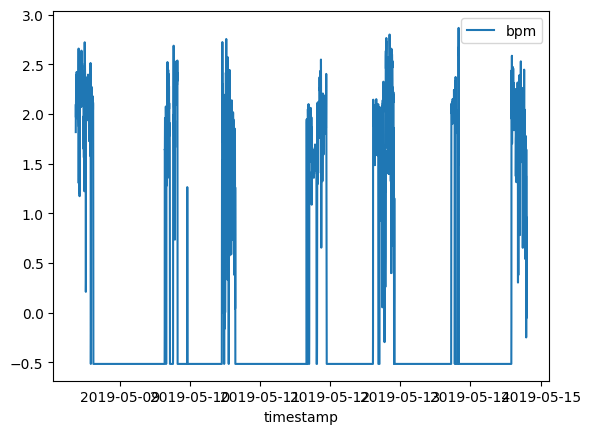

In [162]:
# Plot

sns.lineplot(data=df);

## Finding "Home" for each participant

In [ ]:
34.3160    36.3636   74.2000     43
34.3178    36.3738

<AxesSubplot:xlabel='timestamp'>

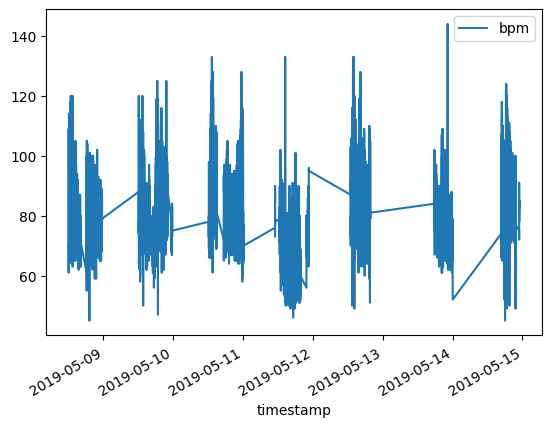

In [194]:
p_code = "P07"
loc_df = df_to_timeseries(pd.read_csv(os.path.join(data_dir,p_code, "Location.csv")))[["longitude","latitude","altitude"]].round(4)
hr_df = df_to_timeseries(pd.read_csv(os.path.join(data_dir,p_code, "HR.csv")))
#loc_df.groupby(["longitude", "latitude", ]).size().sort_values(ascending=False)

hr_df.plot()

In [166]:
loc_df["longitude"].value_counts()

34.314611    11
34.320956     9
34.310937     7
34.318034     5
34.321624     5
             ..
34.320434     1
34.320576     1
34.320485     1
34.320564     1
34.317976     1
Name: longitude, Length: 3138, dtype: int64